# Imports

In [1]:
from src.greeks import *
import plotly.graph_objects as go
import plotly_express as px
import pprint
import pickle
import warnings
from IPython.core.display import display, HTML
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

%load_ext autoreload
%autoreload 2

display(HTML("<style>.container { width:60% !important; }</style>"))

warnings.filterwarnings('ignore')


pd.options.plotting.backend = "plotly"


In [2]:
fig_mode = 'png'  # svg for interactive plots


# 1. Description

In this notebook, we will different method to compute the price and the greeks of a european call option based on Monte Carlo simulation, differentiation and Malliavin Calculus.

The considered option has the following parameters : 

In [3]:
x = 100
r = 0.1
sigma = 0.2
T = 1
k = 100

n = 1000


The BS price, delta and gamma values of this option are : 

In [4]:
price_BS = 13.26968584
delta_BS = 0.725747
gamma_BS = 0.01666123


# 2. Price Using MC

$$p(x)=e^{-rT}E[(X_T^x -K)_+]$$

We generate N random paths for the Brownian Motion so we can generate N paths for price of the asset. For each different path, we estimate the payoff and we use the LLN and CLT to estimate $p(x)$ and confidence bounds.

In this simulation, we vary N from N =
1000 to N = 51000 by 2000 and we plot the price, the empirical variance, and the width of the confidence interval.

lso to generate the Brownian motions, we will use a step of 0.001, using the following method seen in the course :


$$
B_{t_{0}}=0, B_{t_{i}}=\sum_{j=1}^{i} \sqrt{t_{j}-t_{j-1}} G_{j} \text{ ; } i>0
$$

where $\left(G_{1}, \ldots G_{n}\right)$ are i.i.d $\mathcal{N}(0,1).$


In [5]:
prices = pd.DataFrame(
    columns=['N', 'price', 'emp_variance', 'emp_std', 'CI_1', 'CI_2'])

for N in range(1000, 10000, 2000):
    price, emp_variance, emp_std, CI_1, CI_2 = euro_call_price(
        x, n, r, sigma, k, T, N)
    prices = prices.append(pd.Series(
        [N, price, emp_variance, emp_std, CI_1, CI_2], index=prices.columns), ignore_index=True)

prices = prices.set_index('N')


In [6]:
prices.head()


,price,emp_variance,emp_std,CI_1,CI_2
N,,,,,
1000.0,13.658755,269.781749,16.425034,12.640721,14.676789
3000.0,13.097751,258.983701,16.092971,12.521872,13.673631
5000.0,13.133057,257.907197,16.059489,12.687911,13.578203
7000.0,13.035208,263.024768,16.218038,12.655276,13.415139
9000.0,13.428093,262.220045,16.193210,13.093538,13.762648


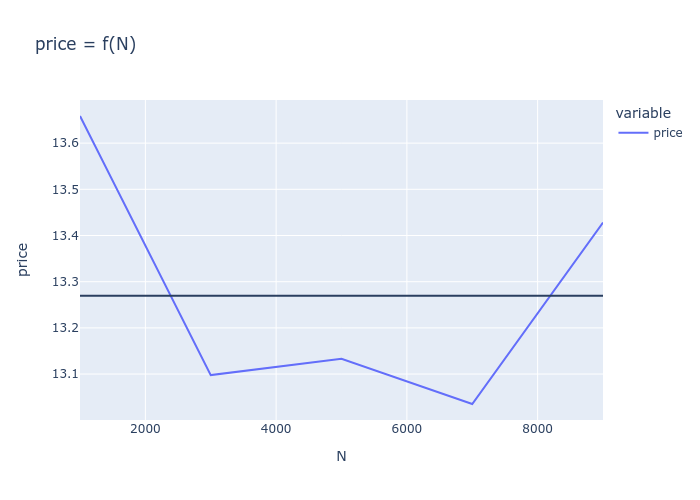

In [7]:
fig = prices.price.plot(title='price = f(N)')
fig.update_layout(yaxis_title='price')
fig.add_hline(y=price_BS)
fig.show(fig_mode)


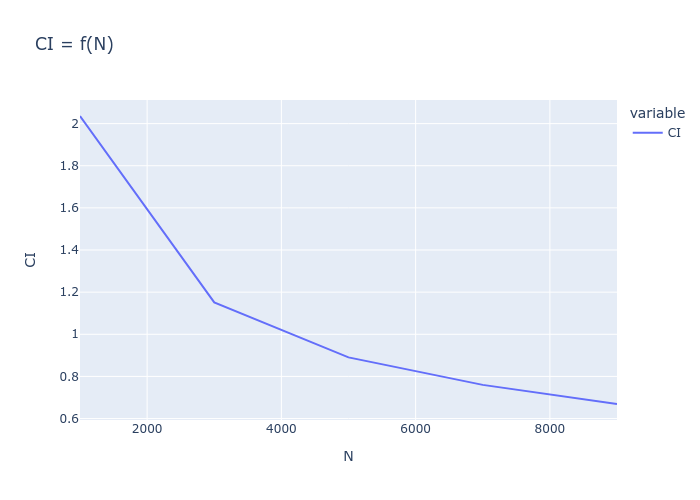

In [8]:
fig = (prices.CI_2 - prices.CI_1).rename('CI').plot(title='CI = f(N)')
fig.update_layout(yaxis_title='CI')
fig.show(fig_mode)


# 3. Greeks using finite difference method

We use the following approximation to estimate $\Delta$ and $\Gamma$:

$$ \Delta(x) = \frac{p(x+h)-p(x-h)}{2h} $$ 
$$ \Gamma(x) = \frac{p(x+h)+p(x-h)-2P(x)}{h^2} $$ 

where $p(x)=e^{-rT}E[(X_T^x -K)_+]$ is estimated using the Monte Carlo Method as in the previous question. The price used paths to estimate $p(x+h)$ and $p(x-h)$ are generated using the same Brownian Motion. 
We have two sources of variance coming from the finite difference method and the MC for the price estimation.

We choose $ℎ = 0.1, ℎ = 0.3, h = 0.2$ and we vary N from N = 1000 to N = 51000 by 2000.

In [ ]:
results_gamma_fd = pd.DataFrame(
    columns=['N', 'h', 'Gamma', 'emp_variance', 'emp_std', 'CI_1', 'CI_2'])
results_delta_fd = pd.DataFrame(
    columns=['N', 'h', 'Delta', 'emp_variance', 'emp_std', 'CI_1', 'CI_2'])

for N in range(1000, 52000, 2000):
    for h in np.linspace(0.1, 0.3, 3):

        (Delta, emp_variance_delta, emp_std_delta, CI_1_delta, CI_2_delta), (Gamma, emp_variance_gamma,
                                                                             emp_std_gamma, CI_1_gamma, CI_2_gamma) = delta_gamma_euro_call_1(x, n, r, sigma, k, T, N, h)
        results_delta_fd = results_delta_fd.append(pd.Series(
            [N, h, Delta, emp_variance_delta, emp_std_delta, CI_1_delta, CI_2_delta], index=results_delta_fd.columns), ignore_index=True)
        results_gamma_fd = results_gamma_fd.append(pd.Series(
            [N, h, Gamma, emp_variance_gamma, emp_std_gamma, CI_1_gamma, CI_2_gamma], index=results_gamma_fd.columns), ignore_index=True)


results_delta_fd = results_delta_fd.set_index(['h', 'N'])
results_gamma_fd = results_gamma_fd.set_index(['h', 'N'])


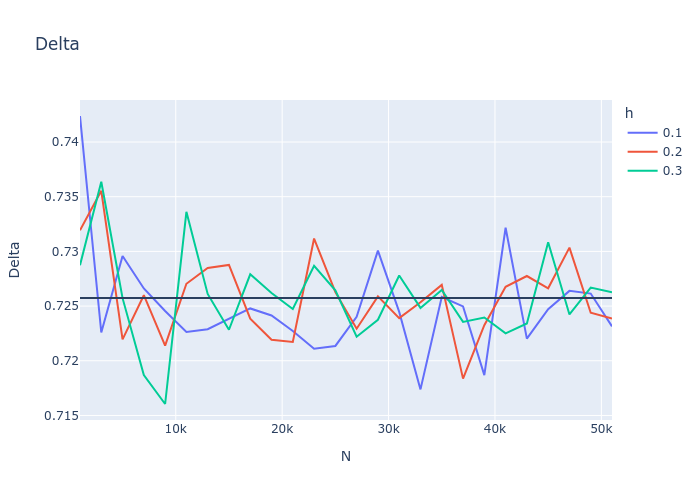

In [15]:
fig = results_delta_fd['Delta'].unstack().T.plot(title='Delta')
fig.update_layout(yaxis_title='Delta')
fig.add_hline(y=delta_BS)
fig.show(fig_mode)


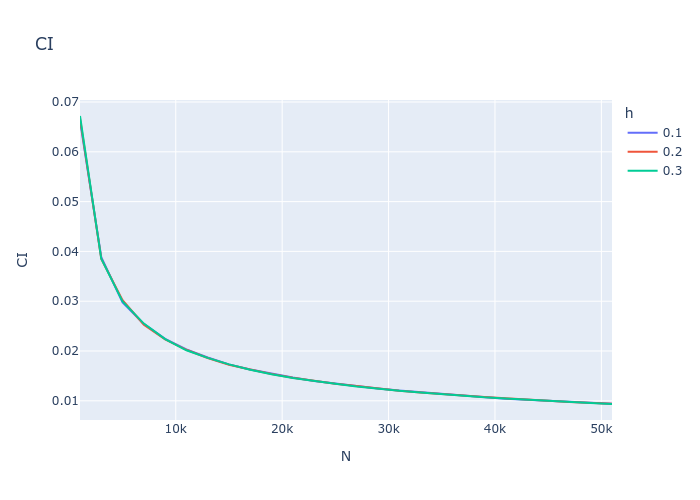

In [16]:
fig = (results_delta_fd['CI_2']-results_delta_fd['CI_1']
       ).unstack().T.plot(title='CI')
fig.update_layout(yaxis_title='CI')
fig.show(fig_mode)


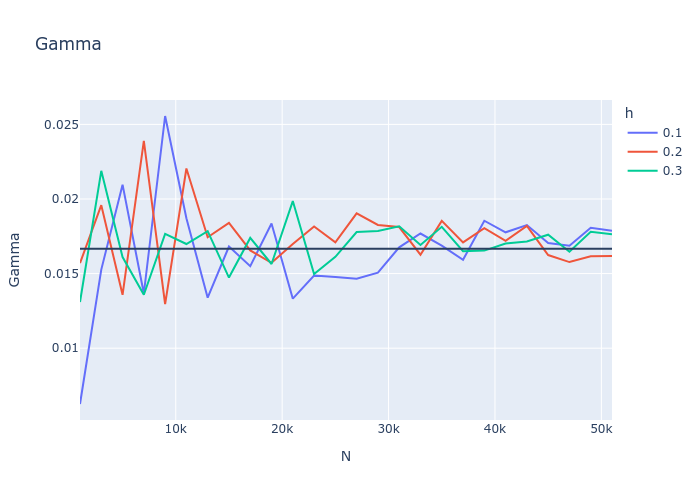

In [17]:
fig = results_gamma_fd['Gamma'].unstack().T.plot(title='Gamma')
fig.update_layout(yaxis_title='Gamma')
fig.add_hline(y=gamma_BS)
fig.show(fig_mode)


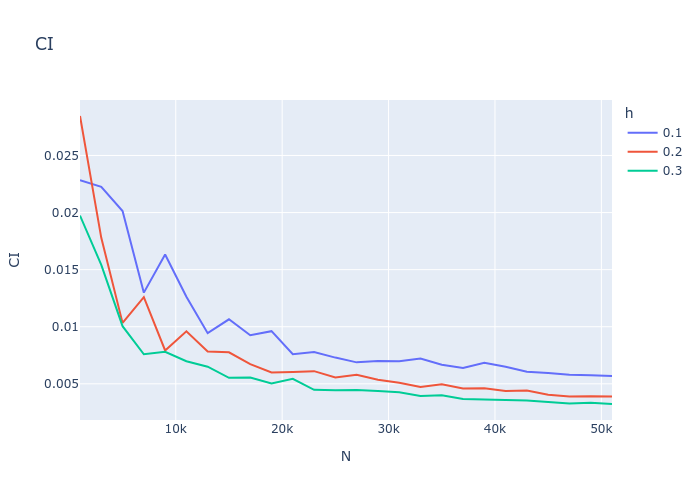

In [18]:
fig = (results_gamma_fd['CI_2']-results_gamma_fd['CI_1']
       ).unstack().T.plot(title='CI')
fig.update_layout(yaxis_title='CI')
fig.show(fig_mode)


# 4. Greeks using MC and Malliavin Calculus

$\Delta(x)=e^{-r T} E\left[\frac{B_{T}}{x \sigma T} F\right]$


$\Gamma(x)=e^{-r T} E\left[\left(\frac{-B_{T}}{x^{2} \sigma T}+\frac{\left(B_{T}\right)^{2}-T}{(\sigma T x)^{2}}\right) F\right]$

We generate N random paths for the Brownian Motion $B_T$ and N paths for price of the asset. For each different path, we estimate the payoff $F$ and  the corresponding $B_T$ to the estimate the final value.

In this simulation, we vary N from N =
1000 to N = 51000 by 2000 and we plot the price and the width of the confidence interval.

In [ ]:
results_delta_mc_1 = pd.DataFrame(
    columns=['N', 'Delta', 'emp_variance', 'emp_std', 'CI_1', 'CI_2'])
results_gamma_mc_1 = pd.DataFrame(
    columns=['N', 'Gamma', 'emp_variance', 'emp_std', 'CI_1', 'CI_2'])

for N in range(1000, 52000, 2000):
    (Delta, emp_variance_delta, emp_std_delta, CI_1_delta, CI_2_delta), (Gamma, emp_variance_gamma,
                                                                         emp_std_gamma, CI_1_gamma, CI_2_gamma) = delta_gamma_euro_call_2(x, n, r, sigma, k, T, N)
    results_delta_mc_1 = results_delta_mc_1.append(pd.Series(
        [N, Delta, emp_variance_delta, emp_std_delta, CI_1_delta, CI_2_delta], index=results_delta_mc_1.columns), ignore_index=True)
    results_gamma_mc_1 = results_gamma_mc_1.append(pd.Series(
        [N, Gamma, emp_variance_gamma, emp_std_gamma, CI_1_gamma, CI_2_gamma], index=results_gamma_mc_1.columns), ignore_index=True)


results_delta_mc_1 = results_delta_mc_1.set_index('N')
results_gamma_mc_1 = results_gamma_mc_1.set_index('N')


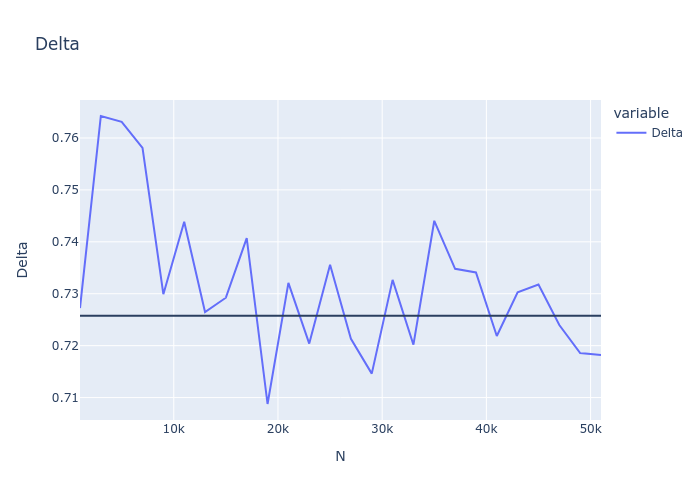

In [22]:
fig = results_delta_mc_1['Delta'].plot(title='Delta')
fig.update_layout(yaxis_title='Delta')
fig.add_hline(y=delta_BS)
fig.show(fig_mode)


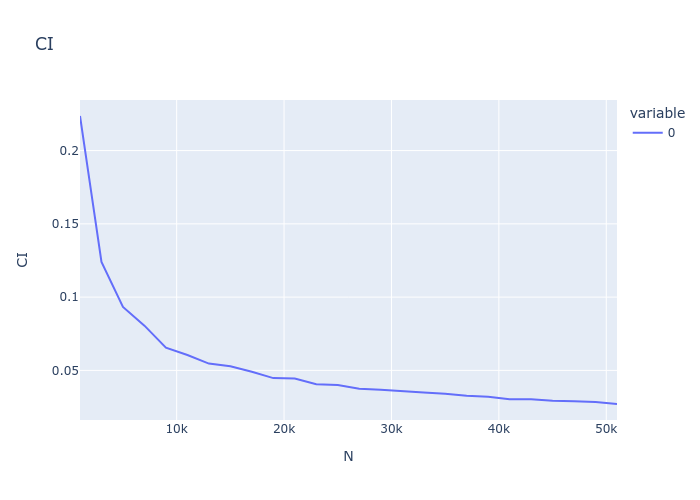

In [23]:
fig = (results_delta_mc_1['CI_2']-results_delta_mc_1['CI_1']).plot(title='CI')
fig.update_layout(yaxis_title='CI')
fig.show(fig_mode)


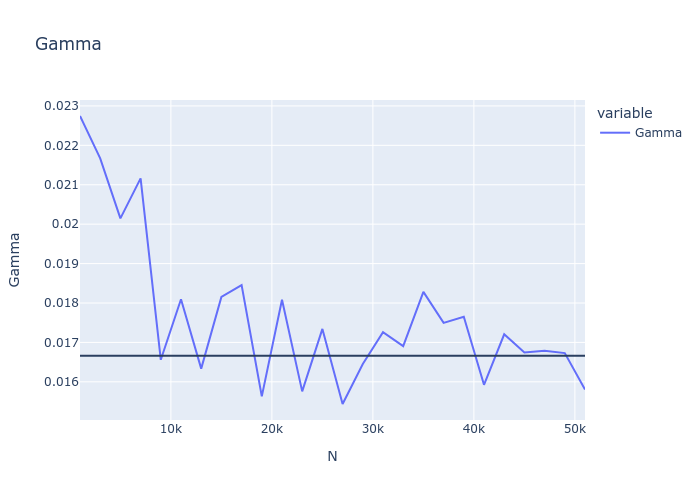

In [24]:
fig = results_gamma_mc_1['Gamma'].plot(title='Gamma')
fig.update_layout(yaxis_title='Gamma')
fig.add_hline(y=gamma_BS)
fig.show(fig_mode)


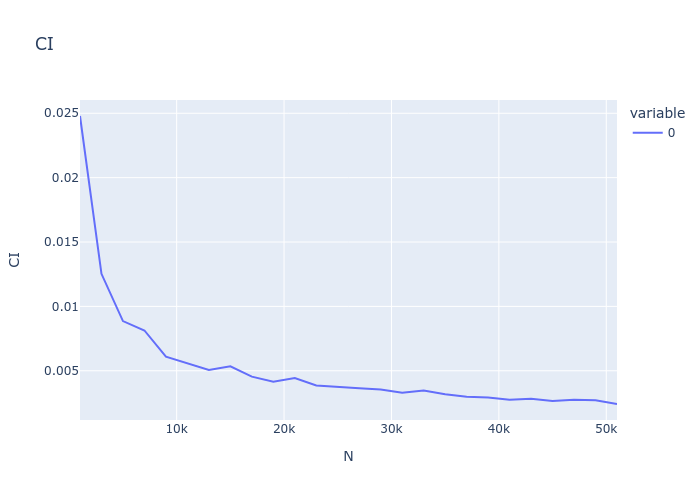

In [25]:
fig = (results_gamma_mc_1['CI_2']-results_gamma_mc_1['CI_1']).plot(title='CI')
fig.update_layout(yaxis_title='CI')
fig.show(fig_mode)


# 5. Greeks using another formula dervied using Malliavin Caluculus
### 5.1 Delta

$$
\begin{array}{c}
H_{\delta}(s)=1_{] K+\delta,+\infty[}(s)+\frac{s-(K-\delta)}{2 \delta} 1_{[K-\delta, K+\delta]}(s) \\
G_{\delta}(t)=\int_{-\infty}^{t} H_{\delta}(s) d s \\
F_{\delta}(t)=(t-K)_{+}-G_{\delta}(t)
\end{array}
$$

$$
\Delta(x)=\frac{e^{-r T}}{x} E\left[H_{\delta}\left(X_{T}^{x}\right) X_{T}^{x}\right]+e^{-r T} E\left[\frac{B_{T}}{x \sigma T} F_{\delta}\left(X_{T}^{x}\right)\right]
$$

In this case, we use N = 51000 and we vary $\delta$ : 2, 10, 55

In [ ]:
deltas = [2, 10, 55]
results_delta_mc_2 = pd.DataFrame(
    columns=['N', 'delta', 'Delta', 'emp_variance', 'emp_std', 'CI_1', 'CI_2'])

N = 51000
for delta in deltas:
    Delta, emp_variance, emp_std, CI_1, CI_2 = delta_euro_call(
        x, n, r, sigma, k, T, N, delta)
    results_delta_mc_2 = results_delta_mc_2.append(pd.Series(
        [N, delta, Delta, emp_variance_delta, emp_std_delta, CI_1_delta, CI_2_delta], index=results_delta_mc_2.columns), ignore_index=True)

results_delta_mc_2 = results_delta_mc_2.set_index('delta')


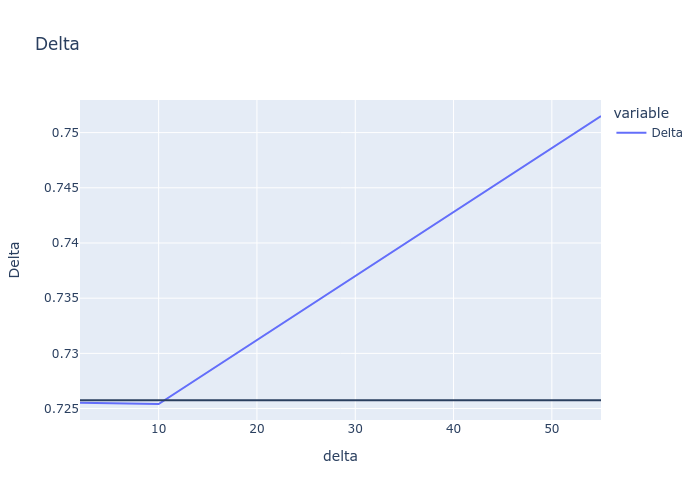

In [27]:
fig = results_delta_mc_2['Delta'].plot(title='Delta')
fig.update_layout(yaxis_title='Delta')
fig.add_hline(y=delta_BS)
fig.show(fig_mode)


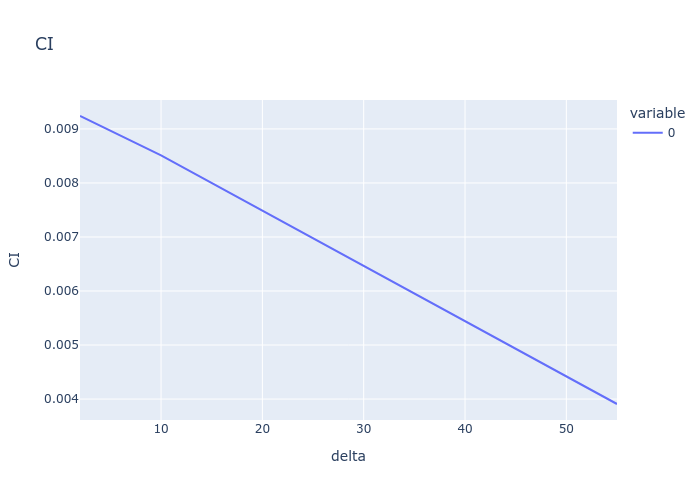

In [28]:
fig = (results_delta_mc_2['CI_2']-results_delta_mc_2['CI_1']).plot(title='CI')
fig.update_layout(yaxis_title='CI')
fig.show(fig_mode)


### 5.2 Gamma

$$
\begin{array}{c}
I_{\delta}(s)=\frac{1}{2 \delta} 1_{[K-\delta, K+\delta]}(s) \\
F_{\delta}(t)=(t-K)_{+}-\int_{-\infty}^{t} \int_{-\infty}^{s} I_{\delta}(u) d u d s
\end{array}
$$

$$
\Gamma(x)=\frac{e^{-r T}}{x^{2}} E\left[I_{\delta}\left(X_{T}^{x}\right)\left(X_{T}^{x}\right)^{2}\right]+e^{-r T} E\left[\left(\frac{-B_{T}}{x^{2} \sigma T}+\frac{\left(B_{T}\right)^{2}-T}{(\sigma T x)^{2}}\right) F_{\delta}\left(X_{T}^{x}\right)\right]
$$

In this case, we use N = 51000 and we vary $\delta$ : 2, 10, 55

In [ ]:
deltas = [2, 10, 55]
results_gamma_mc_2 = pd.DataFrame(
    columns=['N', 'delta', 'Gamma', 'emp_variance', 'emp_std', 'CI_1', 'CI_2'])

N = 51000
for delta in deltas:
    Gamma, emp_variance, emp_std, CI_1, CI_2 = gamma_euro_call(
        x, n, r, sigma, k, T, N, delta)
    results_gamma_mc_2 = results_gamma_mc_2.append(pd.Series(
        [N, delta, Gamma, emp_variance_gamma, emp_std_gamma, CI_1_gamma, CI_2_gamma], index=results_gamma_mc_2.columns), ignore_index=True)

results_gamma_mc_2 = results_gamma_mc_2.set_index('delta')


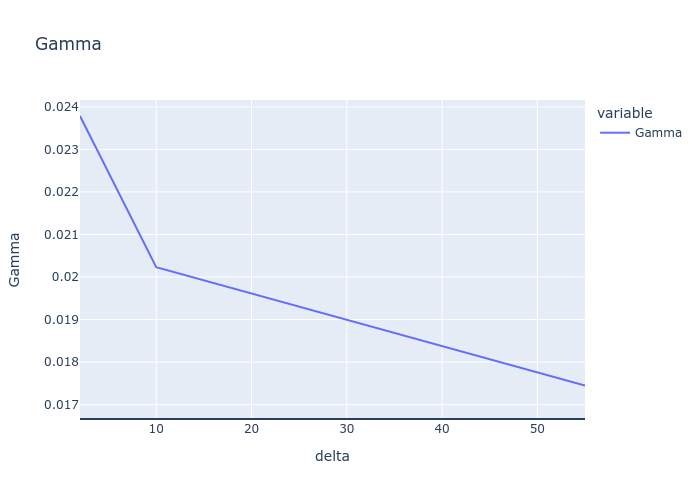

In [29]:
fig = results_gamma_mc_2['Gamma'].plot(title='Gamma')
fig.update_layout(yaxis_title='Gamma')
fig.add_hline(y=gamma_BS)
fig.show(fig_mode)


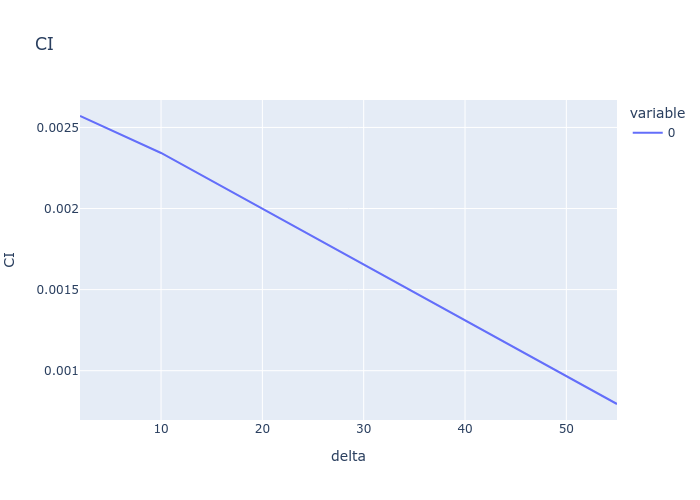

In [30]:
fig = (results_gamma_mc_2['CI_2']-results_gamma_mc_2['CI_1']).plot(title='CI')
fig.update_layout(yaxis_title='CI')
fig.show(fig_mode)
